In [1]:
# Load data from files
from csv import DictReader

with open('data/subset_train_expanded.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_train = [r for r in reader]
csv_file.close()

with open('data/subset_valid_expanded.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_valid = [r for r in reader]
csv_file.close()

with open('data/subset_test_expanded.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_test = [r for r in reader]
csv_file.close()

In [2]:
# Format data into structs for training
from structs import PMDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np

TARGET_VAR = 'TWF'

def pre_format(rows: 'List[dict]', scaler: 'MinMaxScaler' = None) -> 'Tuple[numpy.array, numpy.array]':

    input_vars = [
        'Air temperature [K]',
        'Process temperature [K]',
        'Rotational speed [rpm]',
        'Torque [Nm]',
        'Tool wear [min]'
    ]

    formatted_input = []
    for row in rows:
        _sample = []
        for var in input_vars:
            _sample.append(float(row[var]))
        formatted_input.append(_sample)
    formatted_input = np.asarray(formatted_input)
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(formatted_input)
    formatted_input = scaler.transform(formatted_input)

    formatted_target = []
    for row in rows:
        if row[TARGET_VAR] == '0':
            formatted_target.append([1, 0])
        else:
            formatted_target.append([0, 1])
    formatted_target = np.asarray(formatted_target)

    return (formatted_input, formatted_target, scaler)

X_train, y_train, scaler = pre_format(rows_train)
X_valid, y_valid, _ = pre_format(rows_valid, scaler=scaler)
X_test, y_test, _ = pre_format(rows_test, scaler=scaler)

dataset_train = PMDataset(X_train, y_train)
dataset_valid = PMDataset(X_valid, y_valid)
dataset_test = PMDataset(X_test, y_test)

In [3]:
from structs import SoftmaxMLP, train_model_validate

model = SoftmaxMLP(dataset_train.X.shape[1], 32, dataset_train.y.shape[1])
trained_model, train_loss, valid_loss = train_model_validate(model, dataset_train, dataset_valid, epochs=150, batch_size=8, patience=16, verbose=10, lr=0.001)

Epoch: 0 | Training loss: 0.01934571763626549 | Validation loss: 3.7177278828181206e-05
Epoch: 10 | Training loss: 0.011186513253684326 | Validation loss: 3.315358743315838e-05
Epoch: 20 | Training loss: 0.009958474570488702 | Validation loss: 4.459045002939271e-05


Text(0, 0.5, 'Validation Loss (BCE)')

<Figure size 432x288 with 0 Axes>

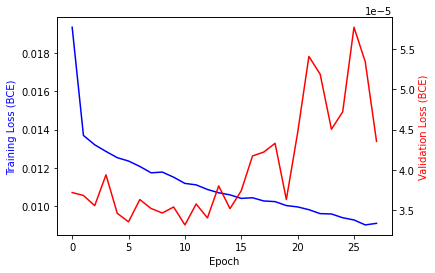

In [4]:
# Plot training loss
from matplotlib import pyplot as plt

epochs = [i for i in range(len(train_loss))]
plt.clf()
fix, ax = plt.subplots()
ax.plot(epochs, train_loss, color='blue')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (BCE)', color='blue')
ax2 = ax.twinx()
ax2.plot(epochs, valid_loss, color='red')
ax2.set_ylabel('Validation Loss (BCE)', color='red')

In [5]:
y_train_hat = model(dataset_train.X).detach().numpy()
_temp = np.zeros_like(y_train_hat)
_temp[np.arange(len(y_train_hat)), y_train_hat.argmax(1)] = 1
y_train_hat = [np.where(r==1)[0][0] for r in _temp]

y_train = dataset_train.y.detach().numpy()
y_train = [np.where(r==1)[0][0] for r in y_train]

<Figure size 432x288 with 0 Axes>

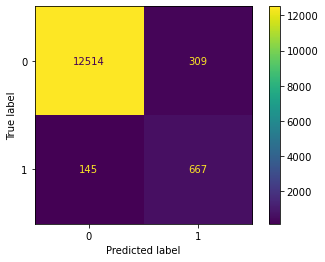

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

plt.clf()
cm = confusion_matrix(y_train, y_train_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [7]:
y_valid_hat = model(dataset_valid.X).detach().numpy()
_temp = np.zeros_like(y_valid_hat)
_temp[np.arange(len(y_valid_hat)), y_valid_hat.argmax(1)] = 1
y_valid_hat = [np.where(r==1)[0][0] for r in _temp]

y_valid = dataset_valid.y.detach().numpy()
y_valid = [np.where(r==1)[0][0] for r in y_valid]

<Figure size 432x288 with 0 Axes>

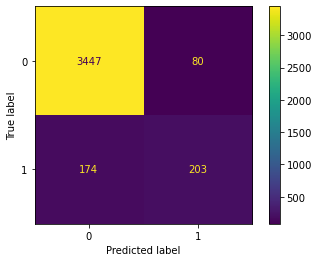

In [8]:
plt.clf()
cm = confusion_matrix(y_valid, y_valid_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [9]:
y_test_hat = model(dataset_test.X).detach().numpy()
_temp = np.zeros_like(y_test_hat)
_temp[np.arange(len(y_test_hat)), y_test_hat.argmax(1)] = 1
y_test_hat = [np.where(r==1)[0][0] for r in _temp]

y_test = dataset_test.y.detach().numpy()
y_test = [np.where(r==1)[0][0] for r in y_test]

<Figure size 432x288 with 0 Axes>

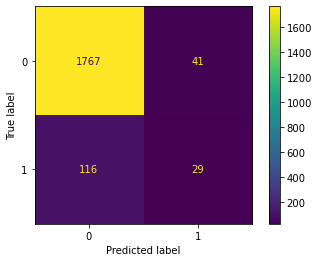

In [10]:
plt.clf()
cm = confusion_matrix(y_test, y_test_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [11]:
print(classification_report(y_train, y_train_hat))
print(classification_report(y_valid, y_valid_hat))
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     12823
           1       0.68      0.82      0.75       812

    accuracy                           0.97     13635
   macro avg       0.84      0.90      0.86     13635
weighted avg       0.97      0.97      0.97     13635

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3527
           1       0.72      0.54      0.62       377

    accuracy                           0.93      3904
   macro avg       0.83      0.76      0.79      3904
weighted avg       0.93      0.93      0.93      3904

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1808
           1       0.41      0.20      0.27       145

    accuracy                           0.92      1953
   macro avg       0.68      0.59      0.61      1953
weighted avg       0.90      0.92      0.91      1953

